Assignment - 3 
# Bird  species Classification 

In [1]:
# Basic Imports

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In this notebook, I am taking the dataset of bird species with 200 classes into consideration for applying Convolutional Neural Networks.

In [2]:
project_name='bird-classification-using-cnn'

# ***Exploring the data***

In [3]:
# Import dataset

data_dir = '../input/100-bird-species'
print('Folders :', os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(len(classes))
print('200 classes :', classes)

Folders : ['consolidated', 'train', 'valid', 'test']
200
200 classes : ['FRIGATE', 'GLOSSY IBIS', 'GOLDEN PHEASANT', 'AMERICAN PIPIT', 'BLACK-CAPPED CHICKADEE', 'RED THROATED BEE EATER', 'EASTERN TOWEE', 'ARARIPE MANAKIN', 'GRAY PARTRIDGE', 'ROCK DOVE', 'RING-BILLED GULL', 'BLACKBURNIAM WARBLER', 'RUFOUS KINGFISHER', 'ELLIOTS  PHEASANT', 'HYACINTH MACAW', 'BOBOLINK', 'AMERICAN BITTERN', 'GOULDIAN FINCH', 'ALBATROSS', 'GREY PLOVER', 'CAPE MAY WARBLER', 'RUBY THROATED HUMMINGBIRD', 'FLAME TANAGER', 'BLACK-THROATED SPARROW', 'ANHINGA', 'CRESTED AUKLET', 'D-ARNAUDS BARBET', 'OSPREY', 'NORTHERN CARDINAL', 'MASKED BOOBY', 'INDIGO BUNTING', 'PURPLE SWAMPHEN', 'CINNAMON TEAL', 'QUETZAL', 'LILAC ROLLER', 'GOLD WING WARBLER', 'CASSOWARY', 'BROWN THRASHER', 'AFRICAN FIREFINCH', 'OCELLATED TURKEY', 'CROWNED PIGEON', 'RED HEADED DUCK', 'KING VULTURE', 'BANANAQUIT', 'OSTRICH', 'ROBIN', 'AMERICAN KESTREL', 'BARN OWL', 'BALD EAGLE', 'RED FACED WARBLER', 'RUFUOS MOTMOT', 'EVENING GROSBEAK', 'MALEO', 'C

In [4]:
dataset = ImageFolder(data_dir + '/train', transform=ToTensor())
print('Size of training dataset :', len(dataset))

Size of training dataset : 27503


In [5]:
test = ImageFolder(data_dir + '/test', transform=ToTensor())
print('Size of test dataset :', len(test))

Size of test dataset : 1000


In [6]:
#1000 test images(20 per class)

In [7]:
img, label = dataset[0]
print(img.shape)

torch.Size([3, 224, 224])


In [8]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  AFRICAN FIREFINCH (0)


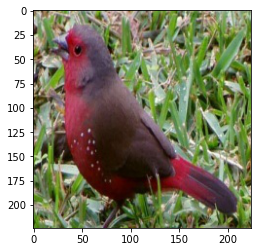

In [9]:
show_example(*dataset[0])

Label:  AMERICAN KESTREL (7)


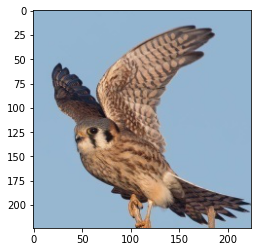

In [10]:
show_example(*dataset[1099])

Label:  RED FACED CORMORANT (148)


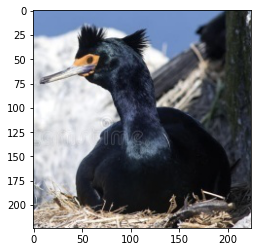

In [11]:
show_example(*dataset[20199])

Label:  CARMINE BEE-EATER (45)


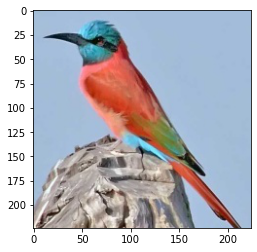

In [12]:
show_example(*dataset[6099])

In [13]:
torch.manual_seed(45)
val_size = 8000
train_size = len(dataset) - val_size

In [14]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(19503, 8000)

In [15]:
batch_size = 256
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size*2, num_workers=4, pin_memory=True)

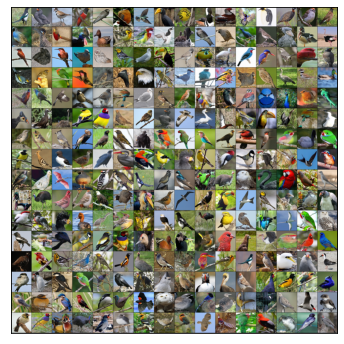

In [16]:
for images, labels in train_loader:
    #images,labels = images.to(device),labels.to(device)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

# *Defining the Model (Convolutional Neural Network)*

In [17]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [18]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)
simple_model.cuda()

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
for images, labels in train_loader:
    #images = images.cuda
    images,labels = images.to(device),labels.to(device)
    print('images.shape:', images.shape)
    out = simple_model(images)
    #out = out.cuda
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([256, 3, 224, 224])
out.shape: torch.Size([256, 8, 112, 112])


In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images,labels = images.to(device),labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images,labels = images.to(device),labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [23]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 224, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(224, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 150 x 16 x 16

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 200 x 8 x 8

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 250 x 4 x 4

            nn.Flatten(), 
            nn.Linear(36000, 1500),
            nn.ReLU(),
            nn.Linear(1500, 1000),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1000, 200))
        
    def forward(self, xb):
        return self.network(xb)

In [24]:
class CnnModel2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 200)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [25]:
model = CnnModel2()
model.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


CnnModel2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [26]:
for images, labels in train_loader:
    images,labels = images.to(device),labels.to(device)
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([256, 3, 224, 224])
out.shape: torch.Size([256, 200])
out[0]: tensor([0.4781, 0.2276, 0.5832, 0.6782, 0.6261, 0.7371, 0.3219, 0.4815, 0.5569,
        0.7259, 0.4548, 0.5127, 0.5854, 0.5610, 0.7368, 0.2763, 0.5229, 0.5092,
        0.4237, 0.5864, 0.5533, 0.4086, 0.5469, 0.3984, 0.5153, 0.6275, 0.4575,
        0.4579, 0.7234, 0.4307, 0.4726, 0.6761, 0.7567, 0.3144, 0.6163, 0.3891,
        0.7994, 0.6668, 0.6546, 0.2797, 0.3733, 0.4198, 0.3483, 0.3565, 0.2660,
        0.8433, 0.2663, 0.3464, 0.5021, 0.1920, 0.3956, 0.4888, 0.5242, 0.3749,
        0.7501, 0.7848, 0.3729, 0.5045, 0.6215, 0.7551, 0.5971, 0.4497, 0.7056,
        0.5997, 0.7107, 0.5624, 0.5639, 0.3120, 0.5472, 0.8016, 0.6279, 0.2859,
        0.5334, 0.8593, 0.3822, 0.2463, 0.3761, 0.6681, 0.5416, 0.8356, 0.4561,
        0.4091, 0.5317, 0.5173, 0.4040, 0.6610, 0.5594, 0.3840, 0.7204, 0.5056,
        0.1736, 0.6534, 0.2575, 0.2102, 0.7084, 0.0928, 0.4828, 0.9036, 0.4013,
        0.1848, 0.6962, 0.5927, 0

In [27]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
#to_device(model, device);

# ***Training the second model***

In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            #batches = batches.to(device)
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [29]:
model = to_device(CnnModel2(), device)

In [30]:
evaluate(model, val_loader)

{'val_loss': 5.307355880737305, 'val_acc': 0.00390625}

In [31]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [32]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 4.6065, val_loss: 4.4762, val_acc: 0.7207
Epoch [1], train_loss: 4.3848, val_loss: 4.4737, val_acc: 0.7122
Epoch [2], train_loss: 4.3528, val_loss: 4.4376, val_acc: 0.7631
Epoch [3], train_loss: 4.3389, val_loss: 4.3973, val_acc: 0.8021
Epoch [4], train_loss: 4.3338, val_loss: 4.4109, val_acc: 0.7993
Epoch [5], train_loss: 4.3220, val_loss: 4.3790, val_acc: 0.8650
Epoch [6], train_loss: 4.3178, val_loss: 4.3951, val_acc: 0.8504
Epoch [7], train_loss: 4.3197, val_loss: 4.4520, val_acc: 0.7586
Epoch [8], train_loss: 4.3281, val_loss: 4.4285, val_acc: 0.7613
Epoch [9], train_loss: 4.3261, val_loss: 4.4384, val_acc: 0.7317
Epoch [10], train_loss: 4.3286, val_loss: 4.4060, val_acc: 0.7650
Epoch [11], train_loss: 4.3258, val_loss: 4.4095, val_acc: 0.7729
Epoch [12], train_loss: 4.3219, val_loss: 4.3913, val_acc: 0.8307
Epoch [13], train_loss: 4.3167, val_loss: 4.3911, val_acc: 0.8443
Epoch [14], train_loss: 4.3161, val_loss: 4.3856, val_acc: 0.8357
Epoch [15], train_lo

In [33]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

# ***Plotting the accuracies***

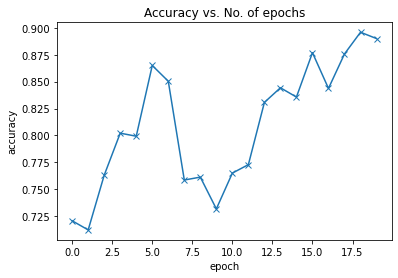

In [34]:
plot_accuracies(history)

In [35]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

# ***Plotting the accuracies***

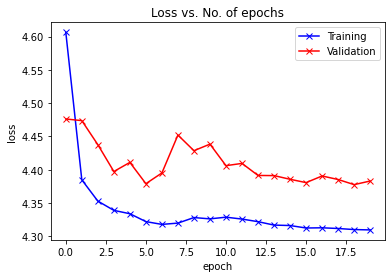

In [36]:
plot_losses(history)

In [37]:
evaluate(model, test_loader)

{'val_loss': 4.325286388397217, 'val_acc': 0.9406538009643555}

# ***The accuracy is: 94.06%***

In [39]:
!pip install jovian --upgrade -q

In [40]:
import jovian

<IPython.core.display.Javascript object>

In [41]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/mitra-krati/bird-classification-using-cnn


<IPython.core.display.Javascript object>